In [1]:
import numpy as np
from PIL import Image
import ctypes
import matplotlib.pyplot as plt
import random
import os

In [2]:
# directory_inputs = ["../database/mnist_dataset/trainingSet/trainingSet/0", "../database/mnist_dataset/trainingSet/trainingSet/1", "../database/mnist_dataset/trainingSet/trainingSet/2", "../database/mnist_dataset/trainingSet/trainingSet/3", "../database/mnist_dataset/trainingSet/trainingSet/4", "../database/mnist_dataset/trainingSet/trainingSet/5", "../database/mnist_dataset/trainingSet/trainingSet/6", "../database/mnist_dataset/trainingSet/trainingSet/7", "../database/mnist_dataset/trainingSet/trainingSet/8", "../database/mnist_dataset/trainingSet/trainingSet/9"]

directory_inputs = ["../database/mnist_dataset/trainingSet/trainingSet/0", "../database/mnist_dataset/trainingSet/trainingSet/1", "../database/mnist_dataset/trainingSet/trainingSet/2"]

In [3]:
X = []
Y = []

X_test = []
Y_test = []

for i in range(len(directory_inputs)):
    for image_file in os.listdir(directory_inputs[i]):
        random_value = random.uniform(0,1)
        if 'img' in image_file:
            if random_value <= 0.8 :
                if i == 0 :
                    image_file = Image.open(directory_inputs[i]+'/'+image_file)
                    # print(image_file)
                    X.append(np.asarray(image_file))
                    Y.append([1., -1., -1.])
                elif i == 1 :
                    image_file = Image.open(directory_inputs[i]+'/'+image_file)
                    # print(image_file)
                    X.append(np.asarray(image_file))
                    Y.append([-1., 1., -1.])
                elif i == 2 :
                    image_file = Image.open(directory_inputs[i]+'/'+image_file)
                    # print(image_file)
                    X.append(np.asarray(image_file))
                    Y.append([-1.,-1.,1.])
            else:
                if i == 0 :
                    image_file = Image.open(directory_inputs[i]+'/'+image_file)
                    # print(image_file)
                    X_test.append(np.asarray(image_file))
                    Y_test.append([1., -1., -1.])
                elif i == 1 :
                    image_file = Image.open(directory_inputs[i]+'/'+image_file)
                    # print(image_file)
                    X_test.append(np.asarray(image_file))
                    Y_test.append([-1., 1., -1.])
                elif i == 2 :
                    image_file = Image.open(directory_inputs[i]+'/'+image_file)
                    # print(image_file)
                    X_test.append(np.asarray(image_file))
                    Y_test.append([-1.,-1.,1.])


X_test = np.array(X_test, dtype=ctypes.c_float)
X_test_flat = X_test.flatten()/255 * 2 - 1

Y_test = np.array(Y_test, dtype=ctypes.c_float)
Y_test_flat = Y_test.flatten()

X = np.array(X, dtype=ctypes.c_float)
X_flat = X.flatten()/255 * 2 - 1

Y = np.array(Y, dtype=ctypes.c_float)
Y_flat = Y.flatten()

In [4]:
print(len(Y_test_flat))
print(len(Y_flat))

7866
31113


In [5]:
my_lib = ctypes.CDLL(r"..\rust_lib\target\release\rust_lib.dll")

my_lib.delete_float_array.argtypes = [
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int32,
]

my_lib.generate_random_mpl_w.argtypes = [ctypes.POINTER(ctypes.c_float), ctypes.c_int32]
my_lib.generate_random_mpl_w.restype = ctypes.POINTER(ctypes.c_float)

my_lib.delete_float_array.restype = None

layers = np.array([len(X_flat)/len(X), 16, 3], dtype=ctypes.c_float)
LP_c_float = ctypes.POINTER(ctypes.c_float)
layers_pmc = (ctypes.c_float * len(layers))(*layers)
layers_ptr_pmc = ctypes.cast(layers_pmc, LP_c_float)

print(len(layers_pmc))
number_of_layers = len(layers_pmc)
print(layers)
number_of_classes_to_predict = int(layers[-1])

3
[784.  16.   3.]


In [6]:
w_array_ptr = my_lib.generate_random_mpl_w(layers_ptr_pmc, number_of_layers)
w_array = np.ctypeslib.as_array(w_array_ptr, ((785*16 + 17*3,))) #3*16 + 17*16 + 17*3

In [7]:
print(len(w_array))


12611


In [8]:

LP_c_float = ctypes.POINTER(ctypes.c_float)
x_to_predict = (ctypes.c_float * len(X_flat))(*X_flat)
x_to_predict_ptr = ctypes.cast(x_to_predict, LP_c_float)
LP_c_float = ctypes.POINTER(ctypes.c_float)
y_to_predict = (ctypes.c_float * len(Y_flat))(*Y_flat)
y_to_predict_ptr = ctypes.cast(y_to_predict, LP_c_float)

LP_c_float = ctypes.POINTER(ctypes.c_float)
x_to_predict_test = (ctypes.c_float * len(X_test_flat))(*X_test_flat)
x_to_predict_test_ptr = ctypes.cast(x_to_predict_test, LP_c_float)
LP_c_float = ctypes.POINTER(ctypes.c_float)
y_to_predict_test = (ctypes.c_float * len(Y_test_flat))(*Y_test_flat)
y_to_predict_test_ptr = ctypes.cast(y_to_predict_test, LP_c_float)

my_lib.multi_layer_perceptron_accuracy.argtypes = [
    ctypes.POINTER(ctypes.c_float),
    ctypes.POINTER(ctypes.c_float),
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int32,
    ctypes.POINTER(ctypes.c_float),
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int32,
    ctypes.c_int32,
    ctypes.c_int32,
    ctypes.c_float,
    ctypes.c_int32,
    ctypes.c_int32,
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int32,
    ctypes.c_bool,
]
my_lib.multi_layer_perceptron_accuracy.restype = ctypes.POINTER(ctypes.c_float)

In [9]:
pmc_trained_model_accuracy_ptr = my_lib.multi_layer_perceptron_accuracy(
    w_array_ptr,
    y_to_predict_ptr,
    x_to_predict_ptr,
    len(X),  # number of inputs
    y_to_predict_test_ptr,
    x_to_predict_test_ptr,
    len(X_test),
    int(len(X_flat)/len(X)),  # dimension of inputs
    3,  # number of classes to predict
    0.01,  # learning rate
    100,  # epochs
    1,
    layers_ptr_pmc,  # pointeur vers la forme de pmc
    number_of_layers,  # number of layers
    True,
)

pmc_trained_model = np.ctypeslib.as_array(pmc_trained_model_accuracy_ptr, (785*16 + 17*3,))



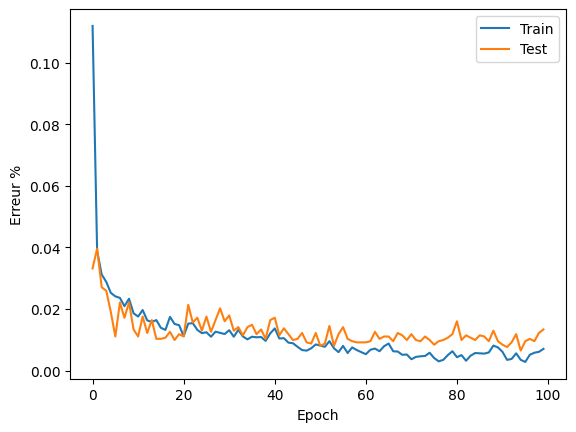

In [10]:
f = open("saved_accuracy.txt", "r")
content = f.readlines()
acc_train = [float(value) for value in content[0].strip().replace(',', ' ').split()]
acc_test = [float(value) for value in content[1].strip().replace(',', ' ').split()]

plt.plot(range(len(acc_train)), acc_train, label='Train')
plt.plot(range(len(acc_test)), acc_test, label='Test')

plt.xlabel('Epoch')
plt.ylabel('Erreur %')

plt.legend()

plt.show()

In [51]:
from PIL import Image, ImageOps
newsize = (28,28)

predict_0 = Image.open("../database/test_set_img_0.jpg").convert('L')
predict_1 = Image.open("../database/test_set_img_1.jpg").convert('L')
predict_2 = Image.open("../database/test_set_img_2.jpg").convert('L')

predict_0 = predict_0.resize(newsize)
predict_1 = predict_1.resize(newsize)
predict_2 = predict_2.resize(newsize)

In [52]:
predict_0 = np.asarray(predict_0)/255 * 2 - 1
predict_1 = np.asarray(predict_1)/255 * 2 - 1
predict_2 = np.asarray(predict_2)/255 * 2 - 1

In [59]:
data_to_predict = np.array([predict_2,predict_1, predict_0],dtype=ctypes.c_float)
data_to_predict_flat =data_to_predict.flatten()

In [60]:
print(data_to_predict_flat)

[-1. -1. -1. ... -1. -1. -1.]


In [61]:
LP_c_float = ctypes.POINTER(ctypes.c_float)
x_to_predict = (ctypes.c_float * len(data_to_predict_flat))(*data_to_predict_flat)
x_to_predict_test_ptr = ctypes.cast(x_to_predict, LP_c_float)

In [62]:
my_lib.multi_layer_perceptron_predict.argtypes = [
    ctypes.POINTER(ctypes.c_float),
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int32,
    ctypes.c_int32,
    ctypes.c_int32,
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int32,
    ctypes.c_bool,
]

my_lib.multi_layer_perceptron_predict.restype = ctypes.POINTER(ctypes.c_float)

# LP_c_float = ctypes.POINTER(ctypes.c_float)
# x_to_predict_mlp = (ctypes.c_float * len(image_a_predire_data_flat))(*image_a_predire_data_flat)
# x_to_predict_ptr_mlp = ctypes.cast(x_to_predict_mlp, LP_c_float)

pmc_predict_ptr = my_lib.multi_layer_perceptron_predict(
    pmc_trained_model_accuracy_ptr,  # pointeur vers le modele entrainé
    x_to_predict_test_ptr,  # pointeur vers le dataset à prédire
    len(data_to_predict),  # nombre d'éléments du dataset
    int(len(data_to_predict_flat)/len(data_to_predict)),  # dimension des éléments du dataset
    3,  # number of classes to predict
    layers_ptr_pmc,  # pointeur vers la forme de pmc
    number_of_layers,  # number of layers
    True,  # is classification
)

pmc_predict_model = np.ctypeslib.as_array(pmc_predict_ptr, (3 * len(data_to_predict),))
# print(pmc_predict_model)
# print(len(X_to_predict))
# print(len(X_to_predict_flat))


In [63]:
for j in range(0,len(pmc_predict_model)-2,3) :
    if pmc_predict_model[j] > pmc_predict_model[j+1] and pmc_predict_model[j] > pmc_predict_model[j+2] :
        print("L'image est un 0")
    elif pmc_predict_model[j+1] > pmc_predict_model[j] and pmc_predict_model[j+1] > pmc_predict_model[j+2] :
        print("L'image est un 1")
    elif pmc_predict_model[j+2] > pmc_predict_model[j] and pmc_predict_model[j+2] > pmc_predict_model[j+1]:
        print("L'image est un 2")
    else :
        print('résultats non concluants')

L'image est un 2
L'image est un 1
L'image est un 0


In [64]:
pmc_predict_model

array([-0.99999946, -0.99999994,  1.        , -0.99915206,  0.99958795,
       -0.9991619 ,  0.99999225, -0.99999994, -0.9999994 ], dtype=float32)